In [1]:
####################read dataset#########################
import os
import random
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

image_folder = "data/img"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".jpg")]
#image_files

######################split dataset#######################
random.seed(0)
random.shuffle(image_files)
total_images = len(image_files)
train_ratio = 0.8

train_files = image_files[:int(total_images * train_ratio)]
test_files = image_files[int(total_images * train_ratio):]
#print(train_files)
#print(test_files)

In [2]:
#Create a vocabulary dictionary that maps all the unique color tokens from your train and test data as keys to a unique integer value.
item_attr_data = pd.read_csv("data/item_attr_data_cleaned.csv")
color_unique = item_attr_data['clothes_color'].unique()
print("number of colors:",len(color_unique))
color_vocab = sorted(set(color_unique))
color_vocabulary = {w:i for i, w in enumerate(color_vocab)}
#print(color_vocabulary)
for i,j in enumerate(item_attr_data['clothes_color']):
    color_value = color_vocabulary[j]
    item_attr_data.loc[i, "clothes_color"] = color_value

number of colors: 759


In [49]:
###################train dataset label##########################
train_ids=[]
for train_index in train_files:
    parts = train_index.split('/')
    train_ids.append(parts[2][:-4])
    
train_labels = pd.DataFrame(columns=item_attr_data.columns)
train_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in train_ids], axis=0, ignore_index=True)
train_labels = train_labels.drop(columns=['index','img_idx'])
train_color = train_labels.pop('clothes_color')

train_color_np = train_color.to_numpy(dtype=np.int32)
train_labels_np = train_labels.to_numpy(dtype=np.float32)
train_labels_np = (train_labels_np + 1) / 2

###################test dataset label##########################
test_ids=[]
for test_index in test_files:
    parts = test_index.split('/')
    test_ids.append(parts[2][:-4])
    
test_labels = pd.DataFrame(columns=item_attr_data.columns)
test_labels = pd.concat([item_attr_data[item_attr_data['img_idx']==i] for i in test_ids], axis=0, ignore_index=True)
test_labels = test_labels.drop(columns=['index','img_idx'])
test_color = test_labels.pop('clothes_color')

test_color_np = test_color.to_numpy(dtype=np.int32)
test_labels_np = test_labels.to_numpy(dtype=np.float32)
test_labels_np = (test_labels_np + 1) / 2

# print(train_labels_np[:5])
# print(train_color_np[:5])

In [50]:
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (256, 256))
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [51]:
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [52]:
train_color_ids_dataset = tf.data.Dataset.from_tensor_slices(train_color_np)
test_color_ids_dataset = tf.data.Dataset.from_tensor_slices(test_color_np)

train_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(train_labels_np)
test_binary_attributes_dataset = tf.data.Dataset.from_tensor_slices(test_labels_np)

train_dataset = tf.data.Dataset.zip((train_dataset, train_color_ids_dataset, train_binary_attributes_dataset))
test_dataset = tf.data.Dataset.zip((test_dataset, test_color_ids_dataset, test_binary_attributes_dataset))

train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [53]:
print(test_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None), TensorSpec(shape=(None, 463), dtype=tf.float32, name=None))>


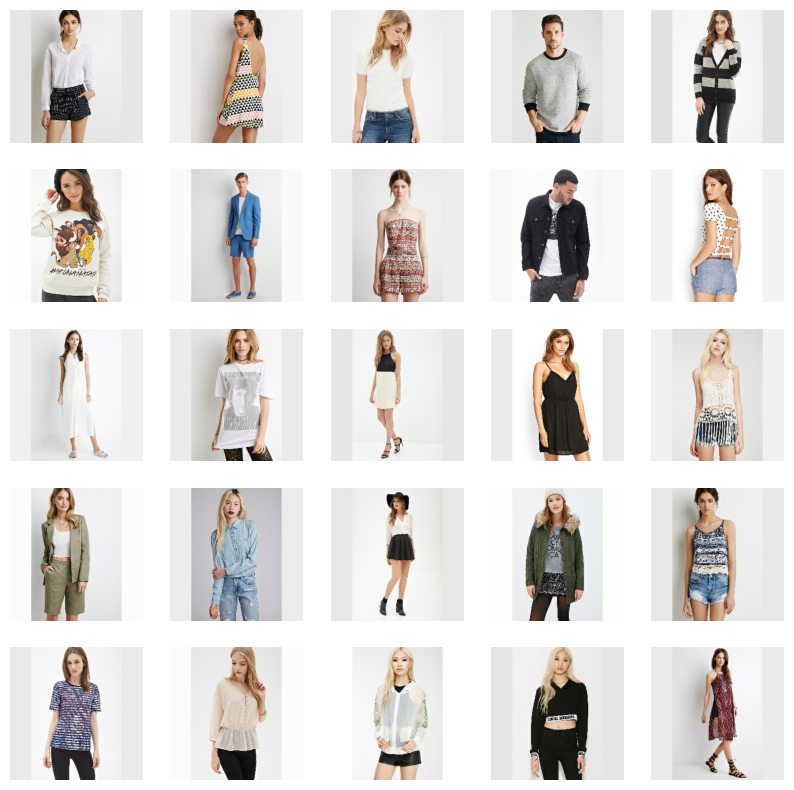

In [54]:
#################show the image####################
# Define a function to display a batch of images
def show_images(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()
    
# Get a batch of images from the train_dataset
for images, color_ids, binary_attributes in train_dataset.take(1):
    show_images(images)

In [62]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Hyperparameters
embedding_dimension = 16
latent_dimension = 128
num_colors = 759
num_binary_attributes = 463
input_shape = (256, 256, 3)

# Cloth color embedding layer
color_embedding = layers.Embedding(num_colors, embedding_dimension, name="color_embedding")

# Encoder
def create_encoder(input_shape, num_attributes):
    inputs = Input(shape=input_shape, name="encoder_input")
    attr_inputs = Input(shape=(num_attributes,), name="attribute_input")
    
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dimension, activation="relu")(x)
    
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_inputs)
    attr_x = layers.Dense(latent_dimension, activation="relu")(attr_x)
    merged = layers.Concatenate()([x, attr_x])   
    
    z_mean = layers.Dense(latent_dimension, name="z_mean")(merged)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(merged)
    
    return Model([inputs, attr_inputs], [z_mean, z_log_var], name="encoder")

# Decoder
def create_decoder(latent_dimension, num_attributes):
    inputs = Input(shape=(latent_dimension + num_attributes,), name="decoder_input")
    
    x = layers.Dense(64 * 64 * 64, activation="relu")(inputs)
    x = layers.Reshape((64, 64, 64))(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    
    outputs = layers.Conv2DTranspose(3, kernel_size=3, padding="same", activation="sigmoid", name="decoder_output")(x)
    
    return Model(inputs, outputs, name="decoder")

# CVAE Model
class CVAE(Model):
    def __init__(self, encoder, decoder, color_embedding, num_binary_attributes, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.color_embedding = color_embedding
        self.num_binary_attributes = num_binary_attributes
    
    def call(self, inputs, training=False):
        images, color_ids, binary_attributes = inputs
        
        # Get color embeddings
        color_embeds = self.color_embedding(color_ids)
        
        # Concatenate color embeddings with binary attributes
        attribute_vector = layers.Concatenate(axis=-1)([color_embeds, binary_attributes])
        
        # Encode input images and attributes
        z_mean, z_log_var = self.encoder([images, attribute_vector])
        
        # Sample from the latent space
        batch_size = tf.shape(images)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dimension))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        
        # Concatenate latent vector with the attribute vector
        z_cond = layers.Concatenate(axis=-1)([z, attribute_vector])
        
        # Decode the conditioned latent vector
        reconstructed_images = self.decoder(z_cond)
        
        return reconstructed_images, z_mean, z_log_var

# Instantiate the encoder, decoder, and VAE model
encoder = create_encoder(input_shape, embedding_dimension + num_binary_attributes)
decoder = create_decoder(latent_dimension, embedding_dimension + num_binary_attributes)
cvae = CVAE(encoder, decoder, color_embedding, num_binary_attributes)

# Loss function and optimizer
reconstruction_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Custom training step
@tf.function
def train_step(images, color_ids, binary_attributes):
    with tf.GradientTape() as tape:
        reconstructed_images, z_mean, z_log_var = cvae([images, color_ids, binary_attributes], training=True)
        
        # Calculate reconstruction loss
        rec_loss = reconstruction_loss(images, reconstructed_images)
        
        # Calculate KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        
        # Combine losses
        total_loss = rec_loss + kl_loss
    
    # Calculate gradients and update model weights
    gradients = tape.gradient(total_loss, cvae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))
    
    return total_loss, rec_loss, kl_loss

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    for batch_images, batch_color_ids, batch_binary_attributes in train_dataset:
        total_loss, rec_loss, kl_loss = train_step(batch_images, batch_color_ids, batch_binary_attributes)
        print(f"Total loss: {total_loss:.4f}, Reconstruction loss: {rec_loss:.4f}, KL loss: {kl_loss:.4f}")

Epoch 1/10
Total loss: 2.1972, Reconstruction loss: 0.1573, KL loss: 2.0399
Total loss: 22.1477, Reconstruction loss: 0.1617, KL loss: 21.9860
Total loss: 2.1305, Reconstruction loss: 0.1585, KL loss: 1.9720
Total loss: 1.5061, Reconstruction loss: 0.1578, KL loss: 1.3483
Total loss: 1.2965, Reconstruction loss: 0.1599, KL loss: 1.1367
Total loss: 1.3365, Reconstruction loss: 0.1593, KL loss: 1.1773
Total loss: 1.2052, Reconstruction loss: 0.1614, KL loss: 1.0438
Total loss: 1.2779, Reconstruction loss: 0.1588, KL loss: 1.1190
Total loss: 1.0892, Reconstruction loss: 0.1577, KL loss: 0.9315
Total loss: 1.1430, Reconstruction loss: 0.1591, KL loss: 0.9839
Total loss: 1.2036, Reconstruction loss: 0.1609, KL loss: 1.0428
Total loss: 1.0966, Reconstruction loss: 0.1587, KL loss: 0.9380
Total loss: 1.0252, Reconstruction loss: 0.1567, KL loss: 0.8684
Total loss: 1.0564, Reconstruction loss: 0.1546, KL loss: 0.9018
Total loss: 0.9927, Reconstruction loss: 0.1586, KL loss: 0.8341
Total loss: 

Total loss: 0.1948, Reconstruction loss: 0.0525, KL loss: 0.1423
Total loss: 0.1918, Reconstruction loss: 0.0548, KL loss: 0.1370
Epoch 3/10
Total loss: 0.1966, Reconstruction loss: 0.0482, KL loss: 0.1484
Total loss: 0.1916, Reconstruction loss: 0.0497, KL loss: 0.1419
Total loss: 0.1799, Reconstruction loss: 0.0504, KL loss: 0.1296
Total loss: 0.1763, Reconstruction loss: 0.0479, KL loss: 0.1284
Total loss: 0.1837, Reconstruction loss: 0.0490, KL loss: 0.1348
Total loss: 0.1735, Reconstruction loss: 0.0496, KL loss: 0.1239
Total loss: 0.1795, Reconstruction loss: 0.0464, KL loss: 0.1330
Total loss: 0.1825, Reconstruction loss: 0.0430, KL loss: 0.1394
Total loss: 0.1720, Reconstruction loss: 0.0460, KL loss: 0.1261
Total loss: 0.1668, Reconstruction loss: 0.0462, KL loss: 0.1206
Total loss: 0.1826, Reconstruction loss: 0.0422, KL loss: 0.1404
Total loss: 0.1759, Reconstruction loss: 0.0460, KL loss: 0.1299
Total loss: 0.1711, Reconstruction loss: 0.0472, KL loss: 0.1239
Total loss: 0.

Total loss: 0.0934, Reconstruction loss: 0.0415, KL loss: 0.0518
Total loss: 0.0920, Reconstruction loss: 0.0441, KL loss: 0.0479
Total loss: 0.0911, Reconstruction loss: 0.0405, KL loss: 0.0507
Total loss: 0.0927, Reconstruction loss: 0.0436, KL loss: 0.0492
Epoch 5/10
Total loss: 0.0912, Reconstruction loss: 0.0389, KL loss: 0.0523
Total loss: 0.0917, Reconstruction loss: 0.0404, KL loss: 0.0513
Total loss: 0.0885, Reconstruction loss: 0.0422, KL loss: 0.0463
Total loss: 0.0850, Reconstruction loss: 0.0406, KL loss: 0.0444
Total loss: 0.0904, Reconstruction loss: 0.0419, KL loss: 0.0485
Total loss: 0.0866, Reconstruction loss: 0.0436, KL loss: 0.0430
Total loss: 0.0883, Reconstruction loss: 0.0405, KL loss: 0.0478
Total loss: 0.0873, Reconstruction loss: 0.0381, KL loss: 0.0492
Total loss: 0.0857, Reconstruction loss: 0.0406, KL loss: 0.0451
Total loss: 0.0865, Reconstruction loss: 0.0419, KL loss: 0.0446
Total loss: 0.0891, Reconstruction loss: 0.0383, KL loss: 0.0508
Total loss: 0.

Total loss: 0.0595, Reconstruction loss: 0.0388, KL loss: 0.0207
Total loss: 0.0565, Reconstruction loss: 0.0381, KL loss: 0.0183
Total loss: 0.0614, Reconstruction loss: 0.0409, KL loss: 0.0205
Total loss: 0.0624, Reconstruction loss: 0.0430, KL loss: 0.0194
Total loss: 0.0596, Reconstruction loss: 0.0394, KL loss: 0.0201
Total loss: 0.0619, Reconstruction loss: 0.0423, KL loss: 0.0195
Epoch 7/10
Total loss: 0.0584, Reconstruction loss: 0.0380, KL loss: 0.0203
Total loss: 0.0600, Reconstruction loss: 0.0396, KL loss: 0.0203
Total loss: 0.0588, Reconstruction loss: 0.0412, KL loss: 0.0176
Total loss: 0.0565, Reconstruction loss: 0.0397, KL loss: 0.0168
Total loss: 0.0602, Reconstruction loss: 0.0410, KL loss: 0.0192
Total loss: 0.0596, Reconstruction loss: 0.0429, KL loss: 0.0167
Total loss: 0.0584, Reconstruction loss: 0.0395, KL loss: 0.0189
Total loss: 0.0564, Reconstruction loss: 0.0375, KL loss: 0.0189
Total loss: 0.0566, Reconstruction loss: 0.0394, KL loss: 0.0172
Total loss: 0.

Total loss: 0.0487, Reconstruction loss: 0.0391, KL loss: 0.0096
Total loss: 0.0505, Reconstruction loss: 0.0409, KL loss: 0.0095
Total loss: 0.0477, Reconstruction loss: 0.0384, KL loss: 0.0093
Total loss: 0.0447, Reconstruction loss: 0.0376, KL loss: 0.0071
Total loss: 0.0493, Reconstruction loss: 0.0403, KL loss: 0.0090
Total loss: 0.0508, Reconstruction loss: 0.0422, KL loss: 0.0086
Total loss: 0.0477, Reconstruction loss: 0.0388, KL loss: 0.0089
Total loss: 0.0495, Reconstruction loss: 0.0414, KL loss: 0.0080
Epoch 9/10
Total loss: 0.0457, Reconstruction loss: 0.0373, KL loss: 0.0084
Total loss: 0.0480, Reconstruction loss: 0.0392, KL loss: 0.0088
Total loss: 0.0478, Reconstruction loss: 0.0405, KL loss: 0.0073
Total loss: 0.0466, Reconstruction loss: 0.0394, KL loss: 0.0072
Total loss: 0.0486, Reconstruction loss: 0.0403, KL loss: 0.0082
Total loss: 0.0492, Reconstruction loss: 0.0422, KL loss: 0.0070
Total loss: 0.0471, Reconstruction loss: 0.0390, KL loss: 0.0082
Total loss: 0.

Total loss: 0.0443, Reconstruction loss: 0.0401, KL loss: 0.0042
Total loss: 0.0433, Reconstruction loss: 0.0388, KL loss: 0.0044
Total loss: 0.0432, Reconstruction loss: 0.0386, KL loss: 0.0046
Total loss: 0.0450, Reconstruction loss: 0.0405, KL loss: 0.0046
Total loss: 0.0425, Reconstruction loss: 0.0380, KL loss: 0.0045
Total loss: 0.0403, Reconstruction loss: 0.0372, KL loss: 0.0031
Total loss: 0.0441, Reconstruction loss: 0.0398, KL loss: 0.0044
Total loss: 0.0460, Reconstruction loss: 0.0418, KL loss: 0.0042
Total loss: 0.0426, Reconstruction loss: 0.0381, KL loss: 0.0045
Total loss: 0.0443, Reconstruction loss: 0.0408, KL loss: 0.0034


In [63]:
# Evaluate the trained model on the test dataset
test_loss = []
for batch_images, batch_color_ids, batch_binary_attributes in test_dataset:
    reconstructed_images, z_mean, z_log_var = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    rec_loss = reconstruction_loss(batch_images, reconstructed_images)
    rec_loss = tf.reduce_mean(rec_loss)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    kl_loss = tf.reduce_mean(kl_loss)
    total_loss = rec_loss + kl_loss
    test_loss.append(total_loss)

test_loss = tf.reduce_mean(test_loss)
print(f"Test loss: {test_loss:.4f}")

Test loss: 0.0449


(100, 256, 256, 3)


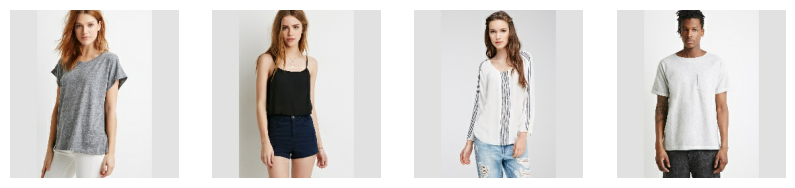

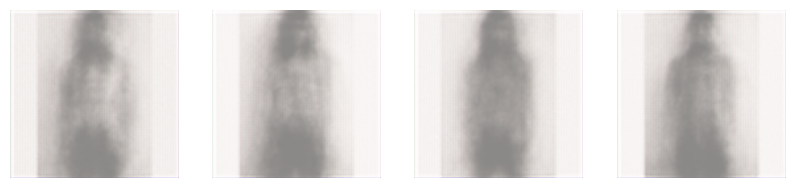

(100, 256, 256, 3)


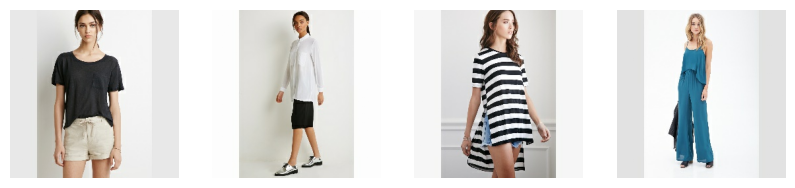

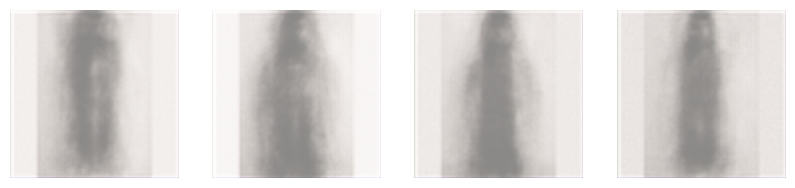

In [66]:
import matplotlib.pyplot as plt

def show(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(1,4,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    plt.show()

for batch_images, batch_color_ids, batch_binary_attributes in test_dataset.take(2):
    reconstructed_images, _, _ = cvae([batch_images, batch_color_ids, batch_binary_attributes])
    show(batch_images)
    show(reconstructed_images)